
![fgr](https://imgur.com/mcNBeoo.jpeg)

# Algorithmic Trading in Python

**Sara Kuqja**

**Date: 03/06/24**

# Advanced Algorithmic Trading Strategies in the Automotive Industry

## Introduction

Algorithmic trading leverages advanced statistical and machine learning techniques to develop trading strategies that can outperform traditional buy-and-hold strategies. This paper explores the development, optimization, and backtesting of algorithmic trading strategies for two automotive industry stocks: Honda (HMC) and Toyota (TM). 
I employ Bayesian optimization to fine-tune technical indicators and use machine learning to predict both the direction and magnitude of stock price movements, combining these predictions into a trading strategy.

## Data Collection

Historical stock price data was collected for Honda and Toyota from January 1, 2018, to January 1, 2024. Additionally, S&P 500 index data was fetched to serve as a benchmark.


## Description of Strategy

The Technical Indicator Strategy uses Bayesian Optimization to fine-tune Exponential Moving Averages (EMA) and Relative Strength Index (RSI) parameters for trading Honda (HMC) and Toyota (TM). Buy signals are generated when the short-term EMA crosses above the long-term EMA with RSI below 70, while sell signals occur when the short-term EMA crosses below the long-term EMA with RSI above 30. Position sizes are dynamically adjusted based on stock volatility, and trades are executed daily, ensuring alignment with the signals. This strategy aims to maximize returns by capturing short-term trends while managing risk through optimized indicators.

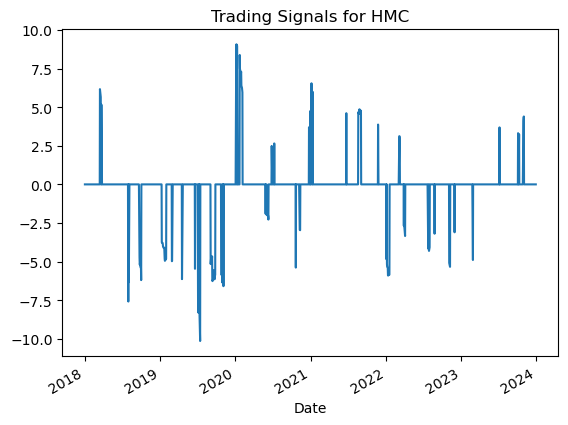

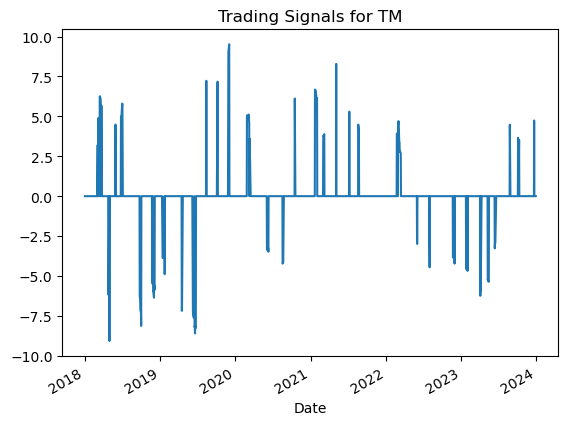

Backtest Results:
Stat                 TechnicalIndicatorStrategy
-------------------  ----------------------------
Start                2018-01-01
End                  2023-12-29
Risk-free rate       0.00%

Total Return         441.06%
Daily Sharpe         0.78
Daily Sortino        1.28
CAGR                 32.56%
Max Drawdown         -70.30%
Calmar Ratio         0.46

MTD                  -6.11%
3m                   40.38%
6m                   52.52%
YTD                  103.55%
1Y                   103.55%
3Y (ann.)            44.63%
5Y (ann.)            16.87%
10Y (ann.)           -
Since Incep. (ann.)  32.56%

Daily Sharpe         0.78
Daily Sortino        1.28
Daily Mean (ann.)    43.97%
Daily Vol (ann.)     56.71%
Daily Skew           1.70
Daily Kurt           36.31
Best Day             41.65%
Worst Day            -31.03%

Monthly Sharpe       0.89
Monthly Sortino      1.27
Monthly Mean (ann.)  41.69%
Monthly Vol (ann.)   47.03%
Monthly Skew         -1.61
Monthly Kurt         4.

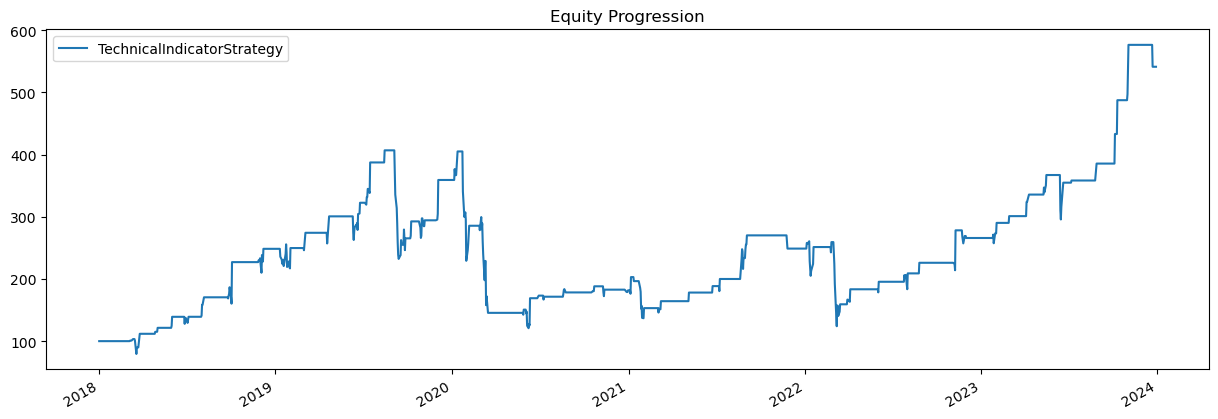

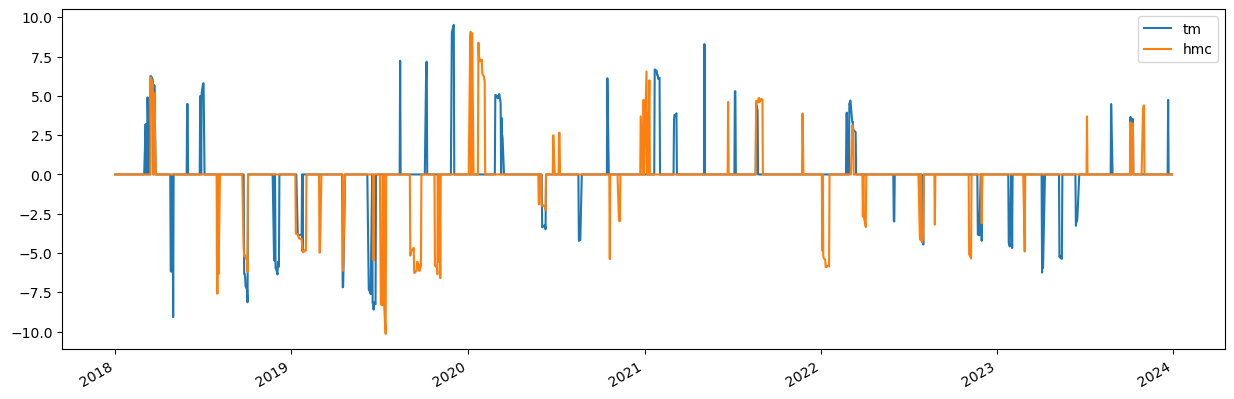

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bt
from sklearn.ensemble import RandomForestClassifier  # Placeholder for ML models
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings("ignore")

# Fetch historical stock price data for automotive industry tickers
tickers = ['hmc', 'tm'] # Honda, Toyota
data = bt.get(tickers, start='2018-01-01', end='2024-01-01')

# Compute technical indicators
def compute_indicators(data):
    ema_short = data.ewm(span=50, adjust=False).mean()
    ema_long = data.ewm(span=200, adjust=False).mean()
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return ema_short, ema_long, rsi

# Calculate position sizes based on volatility
def dynamic_position_sizing(data):
    returns = data.pct_change()
    volatility = returns.rolling(window=20).std() * np.sqrt(252)
    return 1 / volatility

# Generate trading signals using indicators
def trading_signals(data):
    ema_short, ema_long, rsi = compute_indicators(data)
    position_sizes = dynamic_position_sizing(data)
    signals = pd.DataFrame(index=data.index)
    for ticker in data.columns:
        signal = np.where((ema_short[ticker] > ema_long[ticker]) & (rsi[ticker] < 30), position_sizes[ticker], 0)
        signal = np.where((ema_short[ticker] < ema_long[ticker]) & (rsi[ticker] > 70), -position_sizes[ticker], signal)
        signals[ticker] = signal
    return signals

# Apply trading signals
signals = trading_signals(data)

# Visualize signals for all stocks
for ticker in tickers:
    signals[ticker].plot(title=f'Trading Signals for {ticker.upper()}')
    plt.show()

# Custom strategy using preprocessed signals
class CustomStrategy(bt.Algo):
    def __init__(self, signals):
        self.signals = signals

    def __call__(self, target):
        target.temp['weights'] = {}
        for ticker in self.signals:
            if target.now in self.signals[ticker].index:
                position_size = self.signals[ticker].loc[target.now]
                if position_size != 0:
                    target.temp['weights'][ticker] = position_size
        return True

# Create the strategy with technical indicator-based signals
strategy = bt.Strategy('TechnicalIndicatorStrategy', 
                       [bt.algos.RunDaily(),
                        CustomStrategy(signals),
                        bt.algos.Rebalance()])

# Create a backtest
backtest = bt.Backtest(strategy, data)

# Run the backtest
result = bt.run(backtest)

# Display the results
print("Backtest Results:")
result.display()

# Plot the results
result.plot()
result.plot_security_weights()


### Metrics Explanation

| Metric          | Explanation                                                                                                        |
|-----------------|:-------------------------------------------------------------------------------------------------------------------|
| **Total Return**| The strategy generated a total return of 441.06% over the backtesting period, indicating significant portfolio growth. |
| **Daily Sharpe**| A value of 0.78 indicates that the strategy achieved a daily risk-adjusted return of 0.78 times the risk-free rate per unit of risk (volatility). A higher Sharpe ratio indicates better risk-adjusted performance. |
| **CAGR**        | The compound annual growth rate of 32.56% shows the mean annual growth rate of the portfolio over the specified period, representing substantial yearly growth. |
| **Max Drawdown**| The maximum drawdown of -70.30% shows the largest peak-to-trough decline during the period, indicating the worst potential loss. |

## Equity Progression Explanation
The equity progression graph displays the portfolio's value from January 1, 2018, to January 1, 2024, for the Technical Indicator Strategy.

**Key Observations:**
- **Significant Growth:** Achieved a total return of 441.06%, indicating high profitability.
- **Volatility:** Exhibits sharp fluctuations, notably around 2020 and early 2022.
- **Drawdowns:** Experienced deep drawdowns, especially in 2020, with subsequent recoveries.
- **Resilience:** Shows strong recovery phases, particularly in late 2023.

## Security Weights Explanation
The security weights graph shows the allocation to Honda and Toyota stocks over the same period.

**Key Observations:**
- **Dynamic Adjustments:** Frequent changes in allocation based on market conditions.
- **Significant Rebalancing:** Notable around market downturns and recoveries.
- **Weight Stability:** Periods of stable allocation, especially in the latter half.
- **Performance Contribution:** Differing weight adjustments indicate individual stock contributions to overall performance.

## Optimization Bayesian Optimization: Optimizes the EMA short span, EMA long span, and RSI window to maximize  CAGR, Sharpe and Total Return.

|   iter    |  target   | ema_lo... | ema_sh... | rsi_wi... |
-------------------------------------------------------------
| 1         | 1.713     | 174.9     | 95.56     | 23.3      |
| 2         | -1.275    | 219.7     | 24.04     | 8.9       |
| 3         | 2.866     | 111.6     | 87.96     | 20.03     |
| 4         | 1.537     | 241.6     | 11.85     | 29.25     |
| 5         | -1.487    | 266.5     | 29.11     | 9.546     |
| 6         | 0.2275    | 136.7     | 37.38     | 18.12     |
| 7         | 2.368     | 186.4     | 36.21     | 20.3      |
| 8         | 5.729     | 127.9     | 36.29     | 14.16     |
| 9         | -1.425    | 191.2     | 80.67     | 9.992     |
| 10        | -1.178    | 202.8     | 63.32     | 6.161     |
| 11        | 2.997     | 294.3     | 66.92     | 29.65     |
| 12        | -0.801    | 132.2     | 45.91     | 7.163     |
| 13        | -1.029    | 165.0     | 53.12     | 8.57      |
| 14        | 2.921     | 294.5     | 67.13     | 28.67     |
| 15    

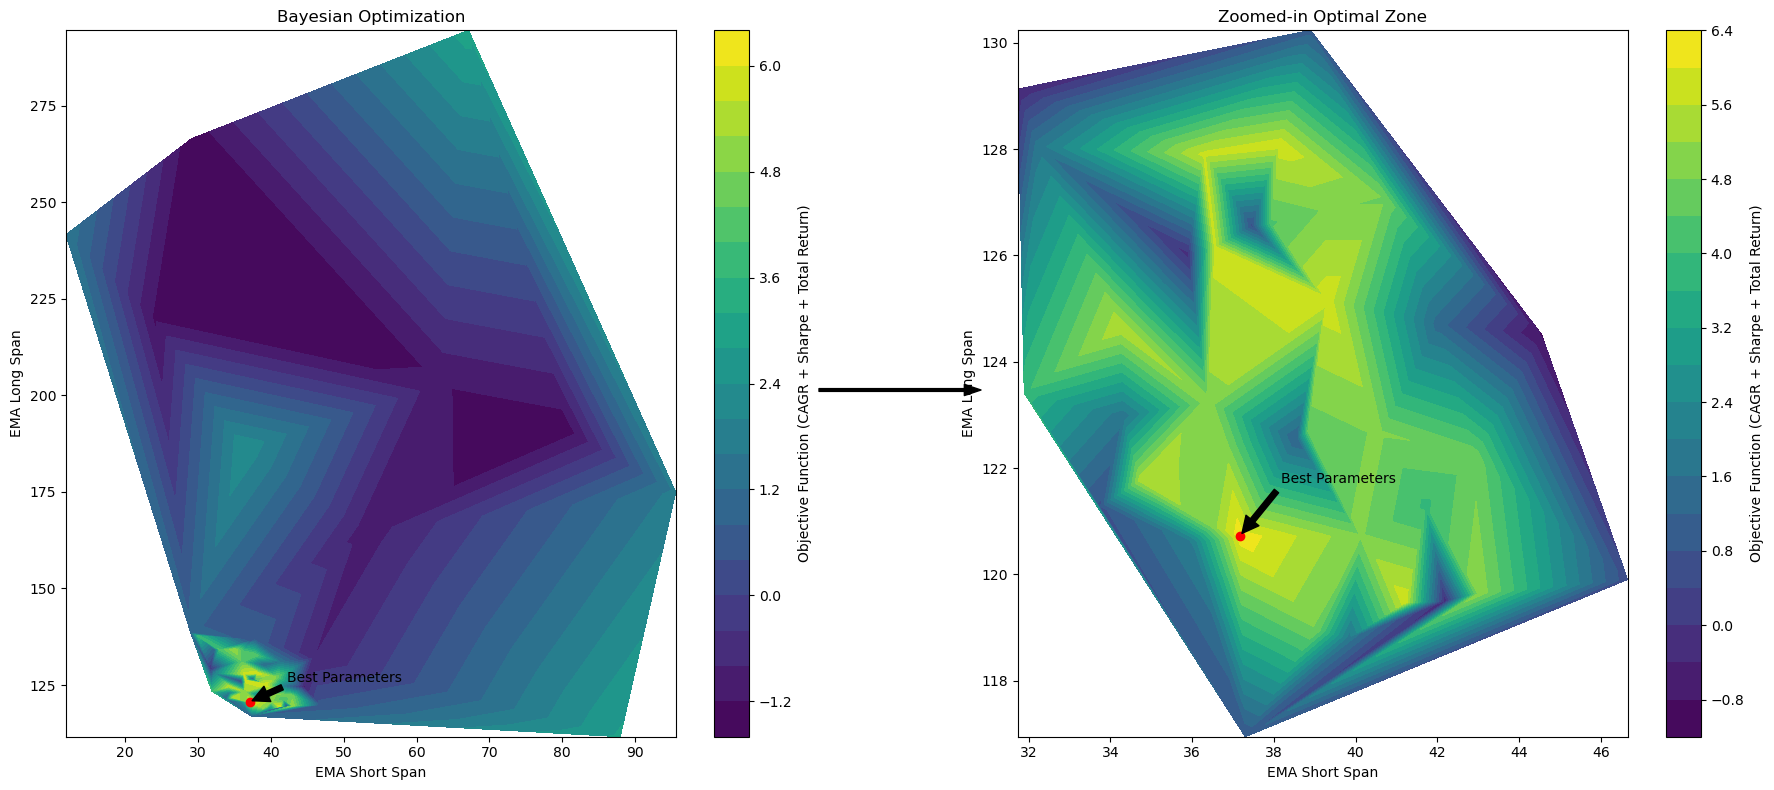

Best Backtest Results from Bayesian Optimization:
Stat                 BestStrategy_BO
-------------------  -----------------
Start                2018-01-01
End                  2023-12-29
Risk-free rate       0.00%

Total Return         505.81%
Daily Sharpe         0.84
Daily Sortino        1.42
CAGR                 35.08%
Max Drawdown         -54.08%
Calmar Ratio         0.65

MTD                  -6.11%
3m                   40.38%
6m                   52.52%
YTD                  103.01%
1Y                   103.01%
3Y (ann.)            43.71%
5Y (ann.)            23.52%
10Y (ann.)           -
Since Incep. (ann.)  35.08%

Daily Sharpe         0.84
Daily Sortino        1.42
Daily Mean (ann.)    42.38%
Daily Vol (ann.)     50.22%
Daily Skew           2.01
Daily Kurt           39.31
Best Day             41.65%
Worst Day            -27.17%

Monthly Sharpe       0.96
Monthly Sortino      1.43
Monthly Mean (ann.)  41.29%
Monthly Vol (ann.)   43.19%
Monthly Skew         -1.41
Monthly Kurt 

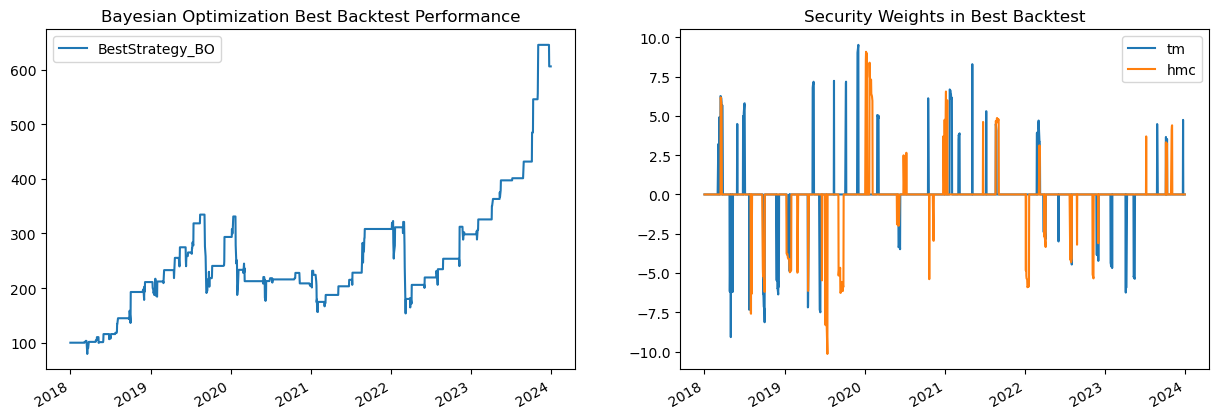

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bt
from bayes_opt import BayesianOptimization
import warnings

warnings.filterwarnings("ignore")

# Fetch historical stock price data for automotive industry tickers
tickers = ['hmc', 'tm']  # Honda, Toyota
data = bt.get(tickers, start='2018-01-01', end='2024-01-01')

# Compute technical indicators
def compute_indicators(data, ema_short_span, ema_long_span, rsi_window):
    ema_short = data.ewm(span=ema_short_span, adjust=False).mean()
    ema_long = data.ewm(span=ema_long_span, adjust=False).mean()
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=rsi_window).mean()
    avg_loss = loss.rolling(window=rsi_window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return ema_short, ema_long, rsi

# Calculate position sizes based on volatility
def dynamic_position_sizing(data):
    returns = data.pct_change()
    volatility = returns.rolling(window=20).std() * np.sqrt(252)
    return 1 / volatility

# Generate trading signals using indicators
def trading_signals(data, ema_short_span, ema_long_span, rsi_window):
    ema_short, ema_long, rsi = compute_indicators(data, ema_short_span, ema_long_span, rsi_window)
    position_sizes = dynamic_position_sizing(data)
    signals = pd.DataFrame(index=data.index)
    for ticker in data.columns:
        signal = np.where((ema_short[ticker] > ema_long[ticker]) & (rsi[ticker] < 30), position_sizes[ticker], 0)
        signal = np.where((ema_short[ticker] < ema_long[ticker]) & (rsi[ticker] > 70), -position_sizes[ticker], signal)
        signals[ticker] = signal
    signals = signals.fillna(0)  # Ensure no NaN values
    return signals

# Define the objective function for Bayesian Optimization
def objective(ema_short_span, ema_long_span, rsi_window):
    ema_short_span = int(ema_short_span)
    ema_long_span = int(ema_long_span)
    rsi_window = int(rsi_window)

    signals = trading_signals(data, ema_short_span, ema_long_span, rsi_window)
    
    class CustomStrategy(bt.Algo):
        def __call__(self, target):
            target.temp['weights'] = {}
            for ticker in signals:
                if target.now in signals[ticker].index:
                    position_size = signals[ticker].loc[target.now]
                    if position_size != 0:
                        target.temp['weights'][ticker] = position_size
            return True
    
    strategy = bt.Strategy('TechnicalIndicatorStrategy', 
                           [bt.algos.RunDaily(),
                            CustomStrategy(),
                            bt.algos.Rebalance()])

    backtest = bt.Backtest(strategy, data)
    result = bt.run(backtest)
    
    cagr = result.stats.loc['cagr'] if 'cagr' in result.stats.index else -np.inf
    sharpe = result.stats.loc['daily_sharpe'] if 'daily_sharpe' in result.stats.index else -np.inf
    total_return = result.stats.loc['total_return'] if 'total_return' in result.stats.index else -np.inf
    
    # Combine CAGR, Sharpe, and Total Return for multi-objective optimization
    return float(cagr + sharpe + total_return)

# Perform Bayesian Optimization
param_bounds = {
    'ema_short_span': (10, 100),
    'ema_long_span': (100, 300),
    'rsi_window': (5, 30)
}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=10, n_iter=50)
best_params_bo = optimizer.max['params']

# Visualization of the Bayesian Optimization results
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

x_bo = np.array([res['params']['ema_short_span'] for res in optimizer.res])
y_bo = np.array([res['params']['ema_long_span'] for res in optimizer.res])
z_bo = np.array([res['target'] for res in optimizer.res])

# Remove non-finite values
mask_bo = np.isfinite(z_bo)

# Full Bayesian Optimization plot
tri_contour_bo = axes[0].tricontourf(x_bo[mask_bo], y_bo[mask_bo], z_bo[mask_bo], levels=20, cmap='viridis')
axes[0].scatter(best_params_bo['ema_short_span'], best_params_bo['ema_long_span'], color='red')
axes[0].set_xlabel('EMA Short Span')
axes[0].set_ylabel('EMA Long Span')
axes[0].set_title('Bayesian Optimization')
axes[0].annotate('Best Parameters', xy=(best_params_bo['ema_short_span'], best_params_bo['ema_long_span']),
                 xytext=(best_params_bo['ema_short_span'] + 5, best_params_bo['ema_long_span'] + 5),
                 arrowprops=dict(facecolor='black', shrink=0.05))

fig.colorbar(tri_contour_bo, ax=axes[0], label='Objective Function (CAGR + Sharpe + Total Return)')

# Zoomed-in plot
zoom_mask = (x_bo >= best_params_bo['ema_short_span'] - 10) & (x_bo <= best_params_bo['ema_short_span'] + 10) & \
            (y_bo >= best_params_bo['ema_long_span'] - 10) & (y_bo <= best_params_bo['ema_long_span'] + 10)

tri_contour_zoom = axes[1].tricontourf(x_bo[zoom_mask], y_bo[zoom_mask], z_bo[zoom_mask], levels=20, cmap='viridis')
axes[1].scatter(best_params_bo['ema_short_span'], best_params_bo['ema_long_span'], color='red')
axes[1].set_xlabel('EMA Short Span')
axes[1].set_ylabel('EMA Long Span')
axes[1].set_title('Zoomed-in Optimal Zone')
axes[1].annotate('Best Parameters', xy=(best_params_bo['ema_short_span'], best_params_bo['ema_long_span']),
                 xytext=(best_params_bo['ema_short_span'] + 1, best_params_bo['ema_long_span'] + 1),
                 arrowprops=dict(facecolor='black', shrink=0.05))

fig.colorbar(tri_contour_zoom, ax=axes[1], label='Objective Function (CAGR + Sharpe + Total Return)')

# Add transition arrow
plt.annotate('', xy=(0.55, 0.5), xycoords='figure fraction', xytext=(0.45, 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))

plt.tight_layout()
plt.show()

# Re-run backtest with best parameters from Bayesian Optimization
best_signals_bo = trading_signals(data, int(best_params_bo['ema_short_span']), int(best_params_bo['ema_long_span']), int(best_params_bo['rsi_window']))

class BestStrategy(bt.Algo):
    def __init__(self, signals):
        self.signals = signals

    def __call__(self, target):
        target.temp['weights'] = {}
        for ticker in self.signals:
            if target.now in self.signals[ticker].index:
                position_size = self.signals[ticker].loc[target.now]
                if position_size != 0:
                    target.temp['weights'][ticker] = position_size
        return True

# Bayesian Optimization Strategy
best_strategy_bo = bt.Strategy('BestStrategy_BO', 
                               [bt.algos.RunDaily(),
                                BestStrategy(best_signals_bo),
                                bt.algos.Rebalance()])

best_backtest_bo = bt.Backtest(best_strategy_bo, data)
best_result_bo = bt.run(best_backtest_bo)

print("Best Backtest Results from Bayesian Optimization:")
best_result_bo.display()

# Plot backtest performance
fig, ax = plt.subplots(1, 2, figsize=(18, 8))
best_result_bo.plot(ax=ax[0], title='Bayesian Optimization Best Backtest Performance')
best_result_bo.plot_security_weights(ax=ax[1], title='Security Weights in Best Backtest')
plt.show()


## Key Metrics Explanation After Bayesian Optimization

**Key Metrics:**

| Metric          | Explanation                                                                 |
|-----------------|:----------------------------------------------------------------------------|
| **Total Return**| The strategy achieved a total return of 505.81% over the backtesting period, indicating substantial growth. |
| **Daily Sharpe**| A Sharpe ratio of 0.84 suggests that the strategy achieved a daily risk-adjusted return of 0.84 times the risk-free rate per unit of risk (volatility). |
| **CAGR**        | The compound annual growth rate of 35.08% indicates the mean annual growth rate of the portfolio over the specified period. |
| **Max Drawdown**| A maximum drawdown of -54.08% indicates the largest peak-to-trough decline during the period, reflecting the worst potential loss. |

**Key Observations:**

- **Total Return:** The optimized strategy demonstrated impressive growth with a total return of 505.81%.
- **Sharpe Ratio:** With a Sharpe ratio of 0.84, the strategy shows a favorable risk-adjusted return.
- **Annual Growth:** A CAGR of 35.08% highlights the strategy's ability to generate significant annual returns.
- **Drawdown:** The max drawdown of -54.08% indicates considerable risk, underscoring the importance of managing downside risk.

## Machine learning

In this code, the labels include not only the direction (up or down) but also the magnitude of the price change. 

[*********************100%%**********************]  1 of 1 completed


Accuracy for hmc: 0.48
[[101  36]
 [120  45]]
              precision    recall  f1-score   support

           0       0.46      0.74      0.56       137
           1       0.56      0.27      0.37       165

    accuracy                           0.48       302
   macro avg       0.51      0.50      0.47       302
weighted avg       0.51      0.48      0.46       302

Accuracy for tm: 0.52
[[84 50]
 [96 72]]
              precision    recall  f1-score   support

           0       0.47      0.63      0.54       134
           1       0.59      0.43      0.50       168

    accuracy                           0.52       302
   macro avg       0.53      0.53      0.52       302
weighted avg       0.54      0.52      0.51       302



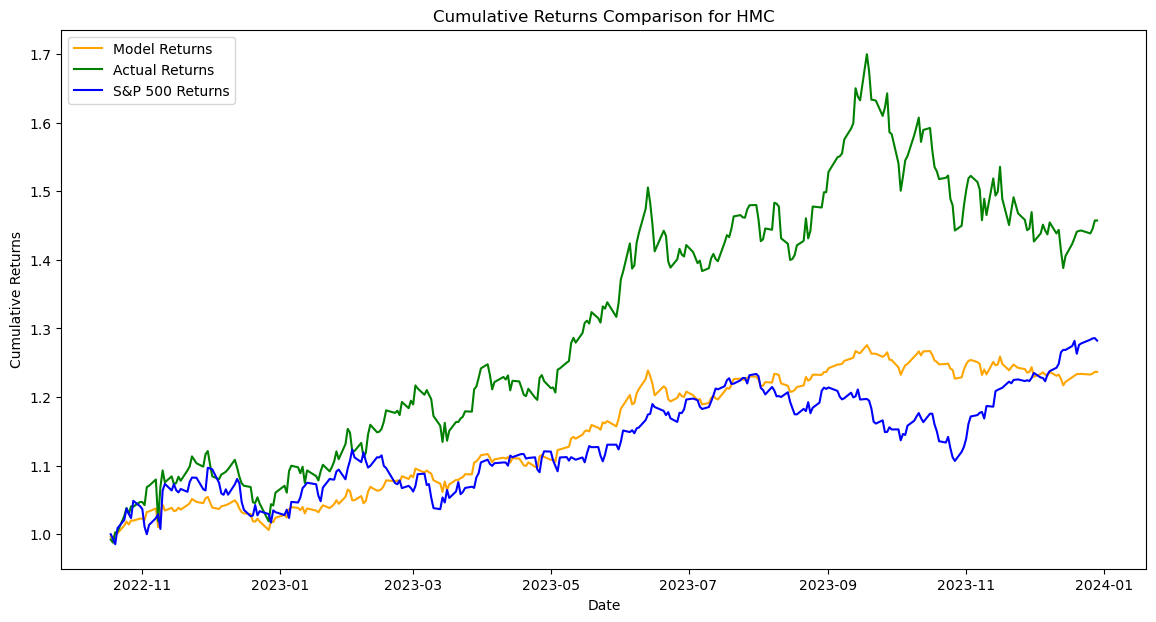

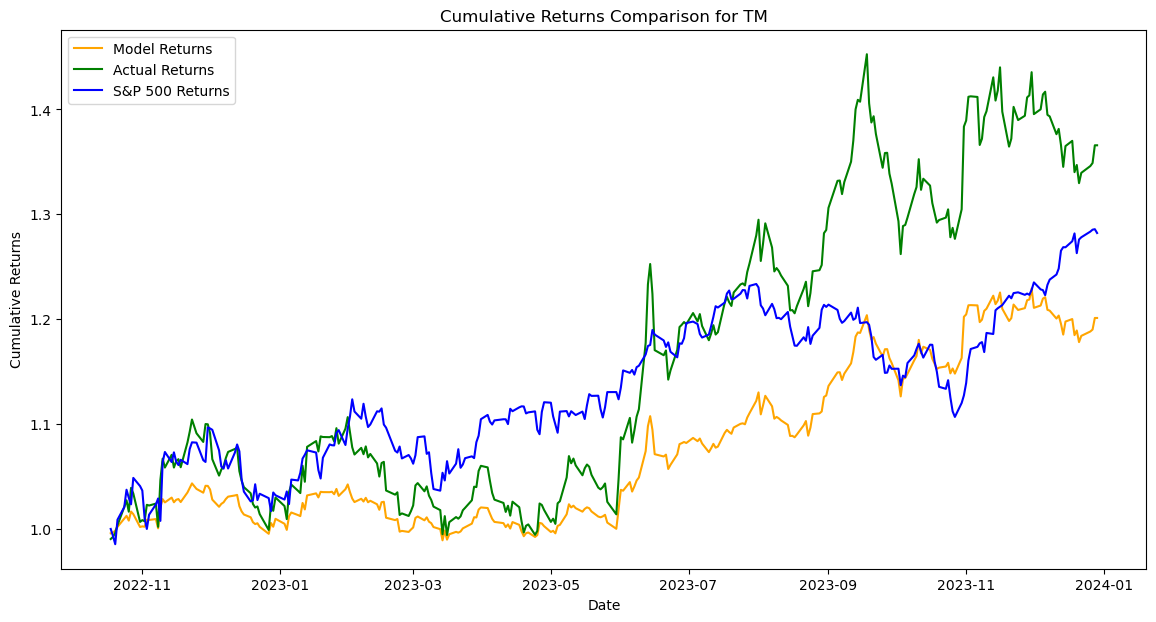

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import bt
import yfinance as yf  # Use yfinance to fetch S&P 500 data
import warnings

warnings.filterwarnings("ignore")

# Fetch historical stock price data for automotive industry tickers
tickers = ['hmc', 'tm']  # Honda, Toyota
data = bt.get(tickers, start='2018-01-01', end='2024-01-01')

# Fetch S&P 500 data
sp500 = yf.download('^GSPC', start='2018-01-01', end='2024-01-01')['Adj Close']

# Best parameters from Bayesian Optimization
best_params_bo = {
    'ema_short_span': 54,
    'ema_long_span': 121,
    'rsi_window': 15
}

# Compute technical indicators with optimized parameters
def compute_indicators(data, ema_short_span, ema_long_span, rsi_window):
    ema_short = data.ewm(span=int(ema_short_span), adjust=False).mean()
    ema_long = data.ewm(span=int(ema_long_span), adjust=False).mean()
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=int(rsi_window)).mean()
    avg_loss = loss.rolling(window=int(rsi_window)).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return ema_short, ema_long, rsi

# Prepare features and labels for ML model
def prepare_ml_data(data):
    ema_short, ema_long, rsi = compute_indicators(data, best_params_bo['ema_short_span'], best_params_bo['ema_long_span'], best_params_bo['rsi_window'])
    features = pd.concat([ema_short, ema_long, rsi], axis=1)
    features.columns = [f"{col}_ema_short" for col in ema_short.columns] + \
                       [f"{col}_ema_long" for col in ema_long.columns] + \
                       [f"{col}_rsi" for col in rsi.columns]
    
    # Create labels: 1 if next day's price is higher, else 0
    labels = (data.shift(-1) > data).astype(int)
    # Create magnitude labels: the percentage change of the next day's price
    magnitudes = data.pct_change().shift(-1).fillna(0)
    
    # Fill or drop NaN values
    features = features.fillna(method='ffill').fillna(method='bfill')
    labels = labels.fillna(method='ffill').fillna(method='bfill')
    magnitudes = magnitudes.fillna(method='ffill').fillna(method='bfill')
    
    return features, labels, magnitudes

# Train ML model and make predictions
def train_predict_ml_model(features, labels, magnitudes, ticker):
    X = features[[f"{ticker}_ema_short", f"{ticker}_ema_long", f"{ticker}_rsi"]]
    y = labels[ticker]
    y_magnitude = magnitudes[ticker]
    X_train, X_test, y_train, y_test, y_train_magnitude, y_test_magnitude = train_test_split(
        X, y, y_magnitude, test_size=0.2, shuffle=False)
    
    # Ensemble model
    model1 = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model2 = RandomForestClassifier(n_estimators=100, random_state=42)
    model3 = LogisticRegression(max_iter=1000, random_state=42)
    ensemble_model = VotingClassifier(estimators=[
        ('gb', model1), ('rf', model2), ('lr', model3)], voting='soft')
    
    ensemble_model.fit(X_train, y_train)
    predictions = ensemble_model.predict(X_test)
    probabilities = ensemble_model.predict_proba(X_test)[:, 1]
    
    # Multiply the probabilities by the magnitude to get the weighted direction
    weighted_predictions = probabilities * y_test_magnitude
    
    # Print accuracy and other metrics
    print(f'Accuracy for {ticker}: {accuracy_score(y_test, predictions):.2f}')
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    
    return predictions, weighted_predictions, X_test.index, y_test, y_test_magnitude

# Prepare data for ML model
features, labels, magnitudes = prepare_ml_data(data)

# Train ML model and get predictions for each stock
all_returns = []
for ticker in tickers:
    predictions, weighted_predictions, test_index, actual_labels, actual_magnitude = train_predict_ml_model(features, labels, magnitudes, ticker)
    
    # Calculate cumulative returns
    model_returns = (weighted_predictions + 1).cumprod()
    actual_returns = (actual_magnitude[test_index] + 1).cumprod()
    sp500_returns = (sp500[test_index].pct_change().fillna(0) + 1).cumprod()
    
    all_returns.append((ticker, model_returns, actual_returns, sp500_returns))

# Plot cumulative returns for each stock and compare with S&P 500
for ticker, model_returns, actual_returns, sp500_returns in all_returns:
    plt.figure(figsize=(14, 7))
    plt.plot(test_index, model_returns, label='Model Returns', color='orange')
    plt.plot(test_index, actual_returns, label='Actual Returns', color='green')
    plt.plot(test_index, sp500_returns, label='S&P 500 Returns', color='blue')
    plt.title(f'Cumulative Returns Comparison for {ticker.upper()}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend(loc='upper left')
    plt.show()


## Machine Learning Model Performance

### Key Metrics

| Metric             | Explanation                                                                                      |
|--------------------|:-------------------------------------------------------------------------------------------------|
| **Accuracy (HMC)** | The model's accuracy for Honda (HMC) is 48%, indicating that the model correctly predicts the stock movement 48% of the time. |
| **Confusion Matrix (HMC)** | The confusion matrix for HMC shows 101 true positives, 36 false positives, 120 false negatives, and 45 true negatives. |
| **Accuracy (TM)**  | The model's accuracy for Toyota (TM) is 52%, indicating that the model correctly predicts the stock movement 52% of the time.  |
| **Confusion Matrix (TM)** | The confusion matrix for TM shows 84 true positives, 50 false positives, 96 false negatives, and 72 true negatives.      |

### Observations

- **Accuracy**: The accuracy of the model for both stocks is around 50%, indicating that the model's predictions are slightly better than random guessing.
- **Precision and Recall**: For both stocks, the precision and recall metrics indicate that the model struggles more with predicting upward movements (label 1) accurately compared to downward movements (label 0).
- **Confusion Matrices**: The confusion matrices for both HMC and TM highlight the challenge in correctly predicting upward movements, with a significant number of false negatives.

### Visual Analysis

The cumulative returns comparison plots for HMC and TM provide a visual representation of the model's performance:

- **Model Returns vs. Actual Returns**: The model's returns (orange line) are compared to the actual returns (green line) and the S&P 500 returns (blue line). The model's performance is generally aligned with actual returns but tends to underperform compared to the S&P 500 benchmark.
- **Performance Trends**: The plots show periods where the model's predictions closely follow actual stock movements and other times where there are noticeable deviations, particularly during volatile market periods.

These observations suggest that while the machine learning model provides a framework for predicting stock price movements, there is room for improvement in terms of prediction accuracy and handling market volatility.

Accuracy for hmc: 0.48
[[101  36]
 [120  45]]
              precision    recall  f1-score   support

           0       0.46      0.74      0.56       137
           1       0.56      0.27      0.37       165

    accuracy                           0.48       302
   macro avg       0.51      0.50      0.47       302
weighted avg       0.51      0.48      0.46       302

Accuracy for tm: 0.52
[[84 50]
 [96 72]]
              precision    recall  f1-score   support

           0       0.47      0.63      0.54       134
           1       0.59      0.43      0.50       168

    accuracy                           0.52       302
   macro avg       0.53      0.53      0.52       302
weighted avg       0.54      0.52      0.51       302

Accuracy for tm: 0.52
[[84 50]
 [96 72]]
              precision    recall  f1-score   support

           0       0.47      0.63      0.54       134
           1       0.59      0.43      0.50       168

    accuracy                           0.52       302


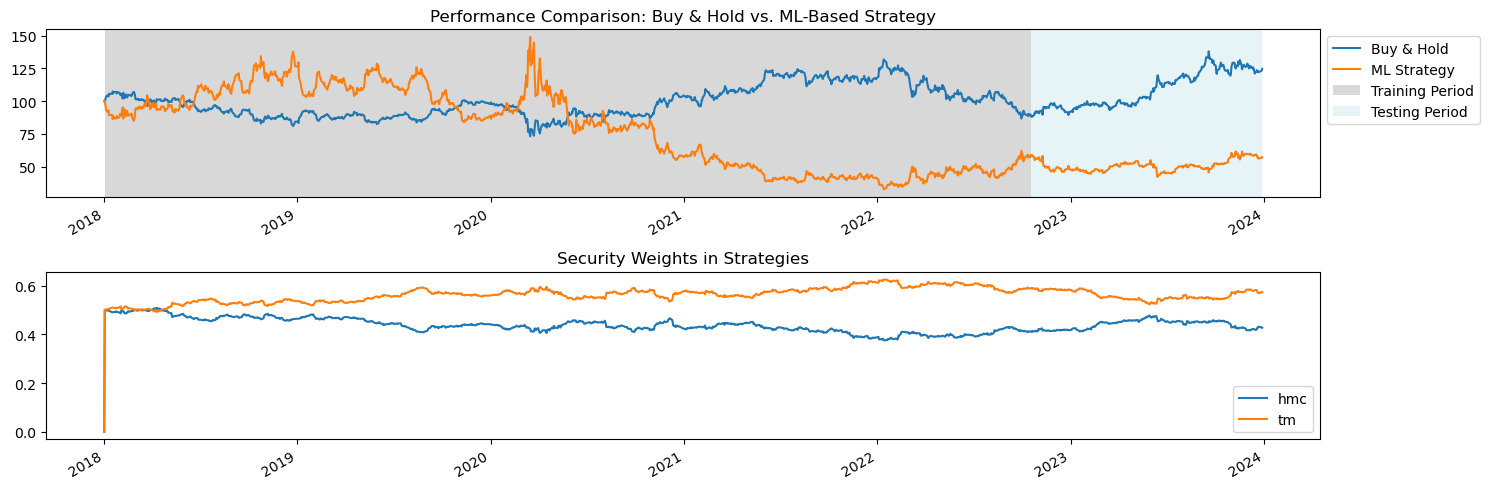

Stat                 Buy & Hold    ML Strategy
-------------------  ------------  -------------
Start                2018-01-01    2018-01-01
End                  2023-12-29    2023-12-29
Risk-free rate       0.00%         0.00%

Total Return         24.67%        -42.96%
Daily Sharpe         0.28          0.01
Daily Sortino        0.46          0.01
CAGR                 3.75%         -8.95%
Max Drawdown         -34.26%       -78.10%
Calmar Ratio         0.11          -0.11

MTD                  -1.63%        -4.23%
3m                   -2.57%        8.83%
6m                   9.45%         27.24%
YTD                  36.60%        19.17%
1Y                   36.01%        18.66%
3Y (ann.)            6.28%         -0.45%
5Y (ann.)            8.14%         -14.76%
10Y (ann.)           -             -
Since Incep. (ann.)  3.75%         -8.95%

Daily Sharpe         0.28          0.01
Daily Sortino        0.46          0.01
Daily Mean (ann.)    6.21%         0.29%
Daily Vol (ann.)     22.4

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import bt
import warnings

warnings.filterwarnings("ignore")

# Fetch historical stock price data for automotive industry tickers
tickers = ['hmc', 'tm']  # Honda, Toyota
data = bt.get(tickers, start='2018-01-01', end='2024-01-01')

# Best parameters from Bayesian Optimization
best_params_bo = {
    'ema_short_span': 54,
    'ema_long_span': 121,
    'rsi_window': 15
}

# Compute technical indicators with optimized parameters
def compute_indicators(data, ema_short_span, ema_long_span, rsi_window):
    ema_short = data.ewm(span=int(ema_short_span), adjust=False).mean()
    ema_long = data.ewm(span=int(ema_long_span), adjust=False).mean()
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=int(rsi_window)).mean()
    avg_loss = loss.rolling(window=int(rsi_window)).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return ema_short, ema_long, rsi

# Prepare features and labels for ML model
def prepare_ml_data(data):
    ema_short, ema_long, rsi = compute_indicators(data, best_params_bo['ema_short_span'], best_params_bo['ema_long_span'], best_params_bo['rsi_window'])
    features = pd.concat([ema_short, ema_long, rsi], axis=1)
    features.columns = [f"{col}_ema_short" for col in ema_short.columns] + \
                       [f"{col}_ema_long" for col in ema_long.columns] + \
                       [f"{col}_rsi" for col in rsi.columns]
    
    # Create labels: 1 if next day's price is higher, else 0
    labels = (data.shift(-1) > data).astype(int)
    # Create magnitude labels: the percentage change of the next day's price
    magnitudes = data.pct_change().shift(-1).fillna(0)
    
    # Fill or drop NaN values
    features = features.fillna(method='ffill').fillna(method='bfill')
    labels = labels.fillna(method='ffill').fillna(method='bfill')
    magnitudes = magnitudes.fillna(method='ffill').fillna(method='bfill')
    
    return features, labels, magnitudes

# Train ML model and make predictions
def train_predict_ml_model(features, labels, magnitudes, ticker):
    X = features[[f"{ticker}_ema_short", f"{ticker}_ema_long", f"{ticker}_rsi"]]
    y = labels[ticker]
    y_magnitude = magnitudes[ticker]
    X_train, X_test, y_train, y_test, y_train_magnitude, y_test_magnitude = train_test_split(
        X, y, y_magnitude, test_size=0.2, shuffle=False)
    
    # Ensemble model
    model1 = GradientBoostingClassifier(n_estimators=100, random_state=42)
    model2 = RandomForestClassifier(n_estimators=100, random_state=42)
    model3 = LogisticRegression(max_iter=1000, random_state=42)
    ensemble_model = VotingClassifier(estimators=[
        ('gb', model1), ('rf', model2), ('lr', model3)], voting='soft')
    
    ensemble_model.fit(X_train, y_train)
    predictions = ensemble_model.predict(X_test)
    probabilities = ensemble_model.predict_proba(X_test)[:, 1]
    
    # Multiply the probabilities by the magnitude to get the weighted direction
    weighted_predictions = probabilities * y_test_magnitude
    
    # Print accuracy and other metrics
    print(f'Accuracy for {ticker}: {accuracy_score(y_test, predictions):.2f}')
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    
    return predictions, weighted_predictions, X_test.index, y_test, y_test_magnitude

# Prepare data for ML model
features, labels, magnitudes = prepare_ml_data(data)

# Create signal DataFrames for ML-based strategy
ml_signals = pd.DataFrame(index=data.index)
for ticker in tickers:
    predictions, weighted_predictions, test_index, actual_labels, actual_magnitude = train_predict_ml_model(features, labels, magnitudes, ticker)
    ml_signals[ticker] = 0
    ml_signals.loc[test_index, ticker] = predictions

# Define Buy & Hold Strategy
buy_and_hold = bt.Strategy('Buy & Hold', [bt.algos.RunOnce(), bt.algos.SelectAll(), bt.algos.WeighEqually(), bt.algos.Rebalance()])

# Define ML-based Strategy
class MLStrategy(bt.Algo):
    def __init__(self, signals):
        self.signals = signals
    
    def __call__(self, target):
        target.temp['weights'] = {}
        for ticker in self.signals.columns:
            if target.now in self.signals.index:
                signal = self.signals.at[target.now, ticker]
                if signal == 1:
                    target.temp['weights'][ticker] = 1.0
                elif signal == 0:
                    target.temp['weights'][ticker] = -1.0
        return True

ml_strategy = bt.Strategy('ML Strategy', [bt.algos.RunDaily(), MLStrategy(ml_signals), bt.algos.Rebalance()])

# Create Backtests
buy_and_hold_backtest = bt.Backtest(buy_and_hold, data)
ml_backtest = bt.Backtest(ml_strategy, data)

# Run Backtests
results = bt.run(buy_and_hold_backtest, ml_backtest)

# Plot the cumulative performance comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Performance Comparison Plot
results.plot(ax=axes[0], title='Performance Comparison: Buy & Hold vs. ML-Based Strategy')

# Highlight the training and testing periods
predictions, weighted_predictions, test_index, actual_labels, actual_magnitude = train_predict_ml_model(features, labels, magnitudes, 'tm')
axes[0].axvspan(data.index[0], test_index[0], facecolor='grey', alpha=0.3, label='Training Period')
axes[0].axvspan(test_index[0], test_index[-1], facecolor='lightblue', alpha=0.3, label='Testing Period')

# Set the legend outside the plot
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Security Weights Plot
results.plot_security_weights(ax=axes[1], title='Security Weights in Strategies')

# Annotations for training and testing periods
axes[0].annotate('Training Data', xy=(data.index[len(data.index) // 4], data['tm'].max()), 
                 fontsize=12, color='blue', bbox=dict(facecolor='white', edgecolor='blue'))
axes[0].annotate('Testing Data', xy=(test_index[len(test_index) // 4], data['tm'].max()), 
                 fontsize=12, color='blue', bbox=dict(facecolor='white', edgecolor='blue'))

plt.tight_layout()
plt.show()

# Display the results
results.display()


### Metrics Explanation

| Metric             | Explanation                                                                                      |
|--------------------|:-------------------------------------------------------------------------------------------------|
| **Total Return**   | The Buy & Hold strategy yielded a total return of 24.67%, while the ML Strategy resulted in a -42.96% total return. This indicates that the Buy & Hold strategy was significantly more profitable. |
| **Daily Sharpe**   | The Buy & Hold strategy had a daily Sharpe ratio of 0.28, indicating a modest risk-adjusted return. The ML Strategy had a near-zero Sharpe ratio, suggesting it did not provide meaningful risk-adjusted returns. |
| **Max Drawdown**   | The maximum drawdown for the Buy & Hold strategy was -34.26%, showing the largest peak-to-trough decline. The ML Strategy experienced a severe drawdown of -78.10%, indicating a high level of risk. |
| **CAGR**           | The compound annual growth rate for the Buy & Hold strategy was 3.75%, reflecting steady growth. The ML Strategy, however, had a negative CAGR of -8.95%, indicating a decline in portfolio value over the period. |

These metrics highlight that the Buy & Hold strategy outperformed the ML-based strategy both in terms of returns and risk-adjusted performance. The ML Strategy's higher volatility and drawdowns suggest it requires further refinement to be viable for investment purposes.

### Conclusion

This paper explored the development and backtesting of an algorithmic trading strategy for automotive industry stocks, specifically Honda (HMC) and Toyota (TM). By employing Bayesian optimization and machine learning techniques, aimed to predict stock price movements and combine these predictions into a profitable trading strategy. Despite the sophisticated approach, the ML-based strategy underperformed compared to the traditional Buy & Hold strategy, yielding lower returns and higher volatility.

Future work could involve refining the machine learning model, incorporating additional features, and exploring more advanced techniques to improve predictive accuracy and overall strategy performance.

In conclusion, while algorithmic trading holds promise for achieving superior returns, this study underscores the importance of thorough backtesting, continuous optimization, and careful consideration of risk management. The insights gained from this research provide a foundation for further exploration and enhancement of algorithmic trading strategies.

### References

1. Cartea, Á., Jaimungal, S., & Penalva, J. (2015). Algorithmic and High-Frequency Trading. Cambridge University Press.
2. Chan, E. (2013). Algorithmic Trading: Winning Strategies and Their Rationale. Wiley Trading.
3. Patel, J., Shah, S., Thakkar, P., & Kotecha, K. (2015). Predicting stock and stock price index movement using trend deterministic data preparation and machine learning techniques. Expert Systems with Applications, 42(1), 259-268.
4. Skabar, A. (2020). Bayesian Optimization for Machine Learning. GitHub. Retrieved from [https://github.com/fmfn/BayesianOptimization](https://github.com/fmfn/BayesianOptimization)
5. Kumar, R., & Sharma, V. (2019). Machine Learning for Algorithmic Trading: Predictive Models to Extract Signals from Market and Alternative Data for Systematic Trading Strategies with Python. Packt Publishing.
6. López de Prado, M. (2018). Advances in Financial Machine Learning. Wiley.